# Computer Vision using CNN and Transfer Learning on CIFAR-10 dataset <br>

# Import Tensorflow, Keras modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Intro_To_AI/Assignment3/q2

Mounted at /content/drive
/content/drive/MyDrive/Intro_To_AI/Assignment3/q2


In [2]:
!pip install tensorflow
!pip install sklearn
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf.__version__)
print(tf.keras.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.8.2
2.8.0


# Data Preparation

## Import CIFAR10 Dataset automatically

In [3]:
# Load training data, labels; and testing data and their true labels
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


## Preprocess CIFAR10 Dataset

### Normalization

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)


### Resize image
Resize original image from (32,32) to (56,56). This is to prepare for dimension matching with Resnet50. <br><br>
Resnet is trained on images with input size (224, 224). We want to convert input size to Resnet pretrained model to be (224, 224). However, due to RAM issue, resizing from (32,32) to (224, 224) was not feasible.<br><br>
To address this, the image is resized to (56,56) first before passing to 2 layers of Upsampling inside the model architecture before entering Resnet50 layer.

In [5]:
# resize training images
minSize = 56

train_images_resized = np.zeros((50000, minSize, minSize, 3,))
for a in range(len(train_images)):
    train_images_resized[a] = cv2.resize(train_images[a], dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)

test_images_resized = np.zeros((10000, minSize, minSize, 3,))
for a in range(len(test_images)):
    test_images_resized[a] = cv2.resize(test_images[a], dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)

print(train_images_resized.shape)
print(test_images_resized.shape)

(50000, 56, 56, 3)
(10000, 56, 56, 3)


### Visualize the dataset

In [6]:
# For printing, we name each of the 10 classes below
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

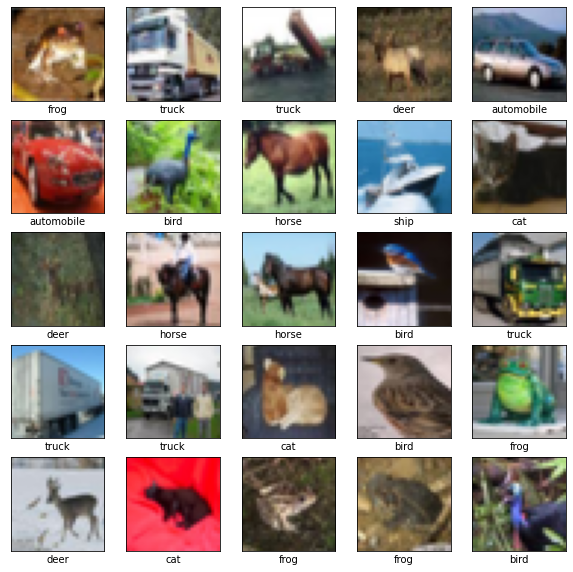

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i].item()])

# Model Training

## Model Setup

### Hyperparameters Definition

In [8]:
## Hyperparameters:
epochs = 30
batch_size = 256
learning_rate = 0.001
dropout_rate = 0.5
es_patience = 5

### Loading and modifying ResNet50 Using Keras API
Resnet50 model with pretrained weights was downloaded. The top layer was excluded to replace with a Dense layer suitable for our classification problem. After some test, we found that the pretrained weight does not work on the CIFAR dataset very well (when freezing all Convolutional layer weights). Hence, the entire network is fine-tuned based on the CIFAR training dataset

In [15]:
# Create the base pre-trained model
# TODO: Question 2.1 and 2.2
base_model = ResNet50(include_top = False, input_shape = (224,224,3),
                 weights='imagenet')
base_model.trainable = True

### Setup Model Architecture

The additional layers added to the architecture are listed as below:
1. UpSampling2D: Size = 2 - To change image dimension to (112,112)
2. UpSamplein2D: Size = 2 - To change image dimension to (224,224)
3. Resnet50: Output Size = (7, 7, 2048)
4. Flatten: Convert 3D matrix input to 1D vector to be fed to several Dense layers subsequently.
5. Dense Layer: 128 nodes, activation function = Relu
6. Dense Layer: 64 nodes, activation function = Relu
7. Dense (Output) Layer: 10 nodes, activation = Softmax. This is the output layer corresponding to the 10 classes to be classified. Softmax Activation function was used to calculate the normalized probability for each class, on which the final predictions will be generated. <br>

Between Dense layers, dropout regularization and batch normalization was performed to help deal with overfitting and assist with model training and stability (reducing internal covariate shift). In addition, data augmentation is also used to try and improve the model ability to generalize.

In [16]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
# TODO: Question 2.3
model = models.Sequential()
model.add(tf.keras.Input(shape=(56,56,3)))
# model.add(data_augmentation)
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))

model.add(base_model)

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(128, activation='LeakyReLU'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='LeakyReLU'))
model.add(layers.Dense(10, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_2 (UpSampling  (None, 112, 112, 3)      0         
 2D)                                                             
                                                                 
 up_sampling2d_3 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                      

### Define optimizer, loss function and monitoring metrics
1. Adam Optimizer was used with learning rate as tunable hyperparameter.
2. Cross Entropy Loss was used for optimization and weight update ('sparse_categorical_crossentropy' using Tensorflow).

In [18]:
# TODO: Question 2.4
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train
Train the model on the training dataset. Use Cross Validation to generate the validation score metrics. <br><br>
Also implemented Early Stopping to prevent model overfitting to the training dataset.<br>
After 5 epochs without improvement in validation accuracy, the model will stop training.

In [19]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = es_patience, verbose=1)
mc = ModelCheckpoint('./q2_model_checkpoint/best_model', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Run the stochastic gradient descent for specified epochs
history = model.fit(train_images_resized, train_labels,
          validation_data = (test_images_resized, test_labels), 
          epochs = epochs, batch_size = batch_size,
          callbacks = [es, mc])

Epoch 1/30
782/782 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.7496
Epoch 1: val_accuracy improved from -inf to 0.33200, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 308s 385ms/step - loss: 0.7410 - accuracy: 0.7496 - val_loss: 2.1312 - val_accuracy: 0.3320
Epoch 2/30
782/782 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.8438
Epoch 2: val_accuracy improved from 0.33200 to 0.79950, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 301s 385ms/step - loss: 0.4601 - accuracy: 0.8438 - val_loss: 0.6113 - val_accuracy: 0.7995
Epoch 3/30
782/782 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8780
Epoch 3: val_accuracy did not improve from 0.79950
782/782 [==============================] - 266s 341ms/step - loss: 0.3560 - accuracy: 0.8780 - val_loss: 0.6366 - val_accuracy: 0.7884
Epoch 4/30
782/782 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.9014
Epoch 4: val_accuracy did not improve from 0.79950
782/782 [==============================] - 266s 341ms/step - loss: 0.2840 - accuracy: 0.9014 - val_loss: 0.9278 - val_accuracy: 0.7407
Epoch 5/30
782/782 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9165
Epoch 5: val_accuracy improved from 0.79950 to 0.81360, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 300s 383ms/step - loss: 0.2427 - accuracy: 0.9165 - val_loss: 0.5904 - val_accuracy: 0.8136
Epoch 6/30
782/782 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9285
Epoch 6: val_accuracy improved from 0.81360 to 0.84050, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 299s 382ms/step - loss: 0.2083 - accuracy: 0.9285 - val_loss: 0.5146 - val_accuracy: 0.8405
Epoch 7/30
782/782 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9454
Epoch 7: val_accuracy did not improve from 0.84050
782/782 [==============================] - 266s 340ms/step - loss: 0.1604 - accuracy: 0.9454 - val_loss: 0.5333 - val_accuracy: 0.8343
Epoch 8/30
782/782 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9473
Epoch 8: val_accuracy did not improve from 0.84050
782/782 [==============================] - 266s 340ms/step - loss: 0.1530 - accuracy: 0.9473 - val_loss: 0.6111 - val_accuracy: 0.8293
Epoch 9/30
782/782 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9575
Epoch 9: val_accuracy improved from 0.84050 to 0.85110, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 299s 382ms/step - loss: 0.1241 - accuracy: 0.9575 - val_loss: 0.5464 - val_accuracy: 0.8511
Epoch 10/30
782/782 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9650
Epoch 10: val_accuracy improved from 0.85110 to 0.85790, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 299s 382ms/step - loss: 0.1044 - accuracy: 0.9650 - val_loss: 0.4915 - val_accuracy: 0.8579
Epoch 11/30
782/782 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9637
Epoch 11: val_accuracy did not improve from 0.85790
782/782 [==============================] - 266s 340ms/step - loss: 0.1064 - accuracy: 0.9637 - val_loss: 0.5002 - val_accuracy: 0.8567
Epoch 12/30
782/782 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9699
Epoch 12: val_accuracy did not improve from 0.85790
782/782 [==============================] - 266s 340ms/step - loss: 0.0882 - accuracy: 0.9699 - val_loss: 0.5372 - val_accuracy: 0.8406
Epoch 13/30
782/782 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9712
Epoch 13: val_accuracy improved from 0.85790 to 0.85980, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 300s 383ms/step - loss: 0.0833 - accuracy: 0.9712 - val_loss: 0.5068 - val_accuracy: 0.8598
Epoch 14/30
782/782 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9723
Epoch 14: val_accuracy improved from 0.85980 to 0.87800, saving model to ./q2_model_checkpoint/best_model


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


INFO:tensorflow:Assets written to: ./q2_model_checkpoint/best_model/assets


782/782 [==============================] - 299s 382ms/step - loss: 0.0816 - accuracy: 0.9723 - val_loss: 0.4423 - val_accuracy: 0.8780
Epoch 15/30
782/782 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9771
Epoch 15: val_accuracy did not improve from 0.87800
782/782 [==============================] - 266s 340ms/step - loss: 0.0675 - accuracy: 0.9771 - val_loss: 0.6234 - val_accuracy: 0.8331
Epoch 16/30
782/782 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9776
Epoch 16: val_accuracy did not improve from 0.87800
782/782 [==============================] - 266s 340ms/step - loss: 0.0654 - accuracy: 0.9776 - val_loss: 0.4838 - val_accuracy: 0.8777
Epoch 17/30
782/782 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9780
Epoch 17: val_accuracy did not improve from 0.87800
782/782 [==============================] - 266s 340ms/step - loss: 0.0630 - accuracy: 0.9780 - val_loss: 0.4859 - val_accuracy: 0.8747
Epoch 18/30
7

# Performance Analysis

### Check Accuracy on Test Data

In [20]:
# Show accuracy of the trained classifier over the entire testing dataset: test_acc
# TODO
model = tf.keras.models.load_model("./q2_model_checkpoint/best_model")

test_loss, test_acc = model.evaluate(test_images_resized, test_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 18s 55ms/step - loss: 0.4423 - accuracy: 0.8780
Test accuracy: 0.878000020980835


## Plot Training/Validation Loss/Accuracy against No of Epochs

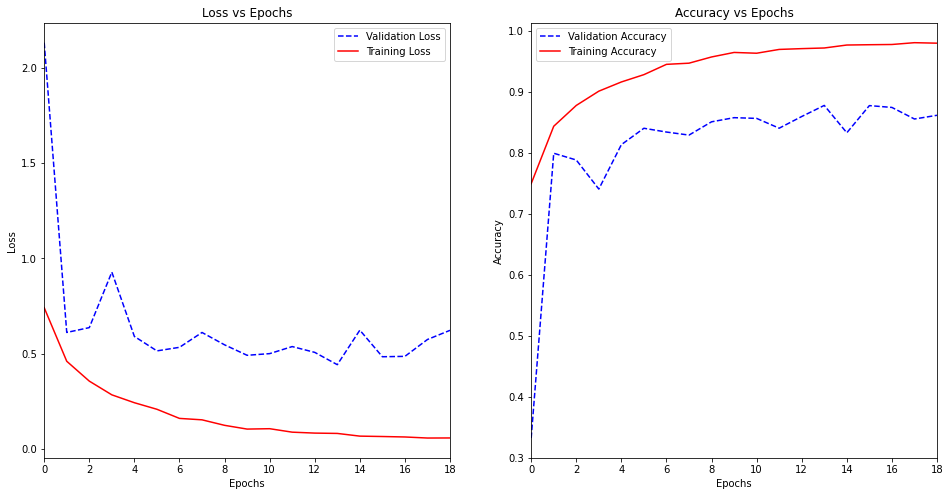

In [21]:
plt.figure(figsize = (16,8))

## Loss Plot
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['val_loss'], '--', label='Validation Loss', color = 'blue')
plt.plot(history.epoch, history.history['loss'], label='Training Loss', color = 'red')
plt.title('Loss vs Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0,max(history.epoch)])

## Validation Accuracy Loss
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='Validation Accuracy', color = 'blue')
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy', color = 'red')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,max(history.epoch)])

plt.show()

### Visualize predictions on test data

In [23]:
# Get all predictions for test data
predictions = model.predict(test_images_resized)

In [24]:
predictions[0]

array([1.1237422e-09, 9.5817099e-10, 4.8539046e-06, 9.9996400e-01,
       3.3033265e-10, 3.1132207e-05, 5.0561000e-09, 1.3059105e-09,
       7.1625479e-09, 4.0322239e-11], dtype=float32)

In [25]:
test_labels[0]

array([3], dtype=uint8)

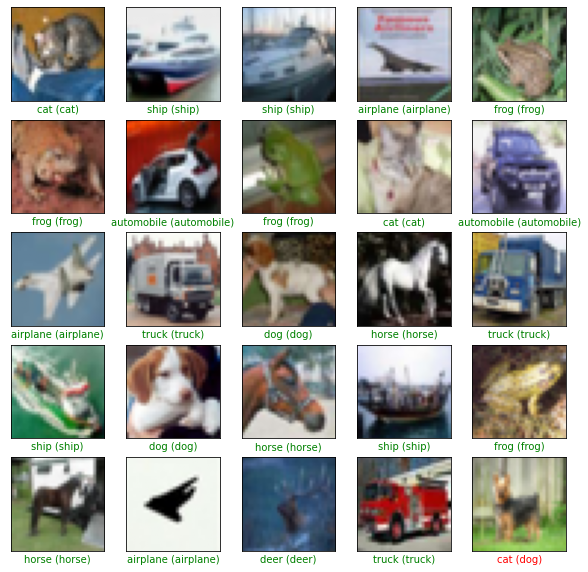

In [26]:
# Code to visualize predictions
# Incorrect predictions are highlighted in red
import numpy as np
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], 
                                  class_names[true_label.item()]),
                                  color=color)